# Chemical-Disease Relation (CDR) Tutorial

In this example, we'll be writing an application to extract *mentions of* **chemical-induced-disease relationships** from Pubmed abstracts, as per the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial will show off some of the more advanced features of Snorkel, so we'll assume you've followed the Intro tutorial.

Let's start by reloading from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
os.environ['SNORKELDB'] = 'postgres:///cdr-structure-learning-2'

from snorkel import SnorkelSession

session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()

In [3]:
print len(train_cands)
print len(dev_cands)

34283
888


# Part III: Writing LFs

This tutorial features some more advanced LFs than the intro tutorial, with more focus on distant supervision and dependencies between LFs.

### Distant supervision approaches

We'll use the [Comparative Toxicogenomics Database](http://ctdbase.org/) (CTD) for distant supervision. The CTD lists chemical-condition entity pairs under three categories: therapy, marker, and unspecified. Therapy means the chemical treats the condition, marker means the chemical is typically present with the condition, and unspecified is...unspecified. We can write LFs based on these categories.

### Note: Mapping `snorkel-biocorpus-new` CIDS to common format

In particular, **we don't yet handle the CHEBI ones!! (TODO!)**:

In [4]:
def map_cids(cids):
    """For now, return MESH only"""    
    return tuple([cid[5:] if cid.startswith("MESH:") else cid for cid in cids])

In [5]:
import bz2
import cPickle

with bz2.BZ2File('data/ctd.pkl.bz2', 'rb') as ctd_f:
    ctd_unspecified, ctd_therapy, ctd_marker = cPickle.load(ctd_f)

In [6]:
def cand_in_ctd_unspecified(c):
    return 1 if map_cids(c.get_cids()) in ctd_unspecified else 0

def cand_in_ctd_therapy(c):
    return 1 if map_cids(c.get_cids()) in ctd_therapy else 0

def cand_in_ctd_marker(c):
    return 1 if map_cids(c.get_cids()) in ctd_marker else 0

In [7]:
def LF_in_ctd_unspecified(c):
    return -1 * cand_in_ctd_unspecified(c)

def LF_in_ctd_therapy(c):
    return -1 * cand_in_ctd_therapy(c)

def LF_in_ctd_marker(c):
    return cand_in_ctd_marker(c)

### Text pattern approaches

Now we'll use some LF helpers to create LFs based on indicative text patterns. We came up with these rules by using the viewer to examine training candidates and noting frequent patterns.

In [8]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return 1 if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1)
def LF_d_induced_by_c_tight(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1)

def LF_induce_name(c):
    return 1 if 'induc' in c.chemical.get_span().lower() else 0     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return 1 if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else 0

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
def LF_d_treat_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_treat_d(c):
    return rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d_wide(c):
    return rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)

def LF_c_d(c):
    return 1 if ('{{A}} {{B}}' in get_tagged_text(c)) else 0

def LF_c_induced_d(c):
    return 1 if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else 0

def LF_improve_before_disease(c):
    return rule_regex_search_before_B(c, 'improv.*', -1)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return -1 if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else 0

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    return rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1)

def LF_induced_other(c):
    return rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)

def LF_far_c_d(c):
    return rule_regex_search_btw_AB(c, '.{100,5000}', -1)

def LF_far_d_c(c):
    return rule_regex_search_btw_BA(c, '.{100,5000}', -1)

def LF_risk_d(c):
    return rule_regex_search_before_B(c, 'risk of ', 1)

def LF_develop_d_following_c(c):
    return 1 if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else 0

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return 1 if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else 0

def LF_measure(c):
    return -1 if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else 0

def LF_level(c):
    return -1 if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else 0

def LF_neg_d(c):
    return -1 if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else 0

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return -1 if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else 0

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


### Composite LFs

The following LFs take some of the strongest distant supervision and text pattern LFs, and combine them to form more specific LFs. These LFs introduce some obvious dependencies within the LF set, which we will model later.

In [9]:
def LF_ctd_marker_c_d(c):
    return LF_c_d(c) * cand_in_ctd_marker(c)

def LF_ctd_marker_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_marker(c)

def LF_ctd_therapy_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_therapy(c)

def LF_ctd_unspecified_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_unspecified(c)

def LF_ctd_unspecified_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_unspecified(c)

### Rules based on context hierarchy

These last two rules will make use of the context hierarchy. The first checks if there is a chemical mention much closer to the candidate's disease mention than the candidate's chemical mention. The second does the analog for diseases.

In [10]:
def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist / 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, dis_start - dist / 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist / 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    for i in range(max(0, chem_start - dist / 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    return 0

### Running the LFs on the training set

In [11]:
LFs = [
    LF_c_cause_d,
    LF_c_d,
    LF_c_induced_d,
    LF_c_treat_d,
    LF_c_treat_d_wide,
    LF_closer_chem,
    LF_closer_dis,
    LF_ctd_marker_c_d,
    LF_ctd_marker_induce,
    LF_ctd_therapy_treat,
    LF_ctd_unspecified_treat,
    LF_ctd_unspecified_induce,
    LF_d_following_c,
    LF_d_induced_by_c,
    LF_d_induced_by_c_tight,
    LF_d_treat_c,
    LF_develop_d_following_c,
    LF_far_c_d,
    LF_far_d_c,
    LF_improve_before_disease,
    LF_in_ctd_therapy,
    LF_in_ctd_marker,
    LF_in_patient_with,
    LF_induce,
    LF_induce_name,
    LF_induced_other,
    LF_level,
    LF_measure,
    LF_neg_d,
    LF_risk_d,
    LF_treat_d,
    LF_uncertain,
    LF_weak_assertions,
]

In [12]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(f=LFs)

In [14]:
%time L_train = labeler.apply(split=0, parallelism=20)
L_train

Clearing existing...
Running UDF...
CPU times: user 56.5 s, sys: 5.18 s, total: 1min 1s
Wall time: 1min 38s


<34283x33 sparse matrix of type '<type 'numpy.float64'>'
	with 38007 stored elements in Compressed Sparse Row format>

### Or, reload labels here:

In [ ]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

In [15]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_c_cause_d,0,0.030190,0.016130,0.007613
LF_c_d,1,0.008517,0.004930,0.001779
LF_c_induced_d,2,0.001808,0.001808,0.000467
LF_c_treat_d,3,0.033632,0.033632,0.004288
LF_c_treat_d_wide,4,0.074964,0.069539,0.009772
LF_closer_chem,5,0.150599,0.109238,0.021060
LF_closer_dis,6,0.018843,0.016014,0.002742
LF_ctd_marker_c_d,7,0.004171,0.004171,0.001079
LF_ctd_marker_induce,8,0.003500,0.003500,0.001021
LF_ctd_therapy_treat,9,0.013826,0.013826,0.004025


# Part IV: Training the generative model

As mentioned above, we want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. We can see that these match up with our prior knowledge. For example, it identified a "reinforcing" dependency between `LF_c_induced_d` and `LF_ctd_marker_induce`. Recall that we constructed the latter using the former.

## For testing without deps

In [16]:
deps = set()

### For testing with deps

In [106]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.15)
len(deps)

22

### Grid search over deps

In [ ]:
import numpy as np
deps_gs = []
threshs = np.arange(0.1, 0.4, 0.025)
for thresh in threshs:
    ds   = DependencySelector()
    deps = ds.select(L_train, threshold=thresh)
    print len(deps)
    deps_gs.append(deps)

In [ ]:
plt.plot(threshs, map(len, deps_gs))

In [ ]:
deps = deps_gs[2]
len(deps)

In [ ]:
deps

Now we'll train the generative model, using the `deps` argument to account for the learned dependencies. We'll also model LF propensity here, unlike the intro tutorial. In addition to learning the accuracies of the LFs, this also learns their likelihood of labeling an example.

In [107]:
L_train

<34283x33 sparse matrix of type '<type 'numpy.float64'>'
	with 38007 stored elements in Compressed Sparse Row format>

In [125]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_prior=False, lf_propensity=True)
gen_model.train(
    L_train, deps=deps, epochs=50, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=0.0, verbose=False, init_acc=2.0
)

In [126]:
train_marginals = gen_model.marginals(L_train)

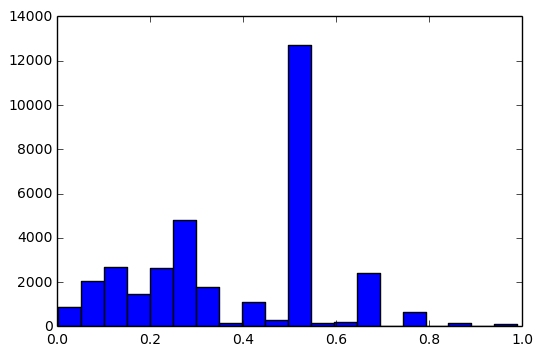

In [127]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [128]:
gen_model.weights.lf_accuracy()

array([ 0.58287638,  0.57114539,  0.5547558 ,  0.58349759,  0.58848373,
        0.62305014,  0.59126603,  0.59716466,  0.5971868 ,  0.57326123,
        0.58426382,  0.57041133,  0.58886357,  0.57941012,  0.58220605,
        0.59536619,  0.59544646,  0.64464256,  0.60875185,  0.59151555,
        0.61299215,  0.57390388,  0.59384921,  0.58072195,  0.59313943,
        0.57831126,  0.59352455,  0.59449878,  0.59251993,  0.5931577 ,
        0.59357006,  0.58838977,  0.60856103])

In [124]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 34283 training marginals


### Checking performance against development set labels

Finally, we'll run the labeler on the development set, load in some external labels, then evaluate the LF performance. The external labels are applied via a small script for convenience. It maps the document-level relation annotations found in the CDR file to mention-level labels. Note that these will not be perfect, although they are pretty good. If we wanted to keep iterating, we could use `snorkel.lf_helpers.test_LF` against the dev set, or look at some false positive and false negative candidates.

In [ ]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=1, annotator='gold')

In [27]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<888x1 sparse matrix of type '<type 'numpy.float64'>'
	with 888 stored elements in Compressed Sparse Row format>

In [129]:
L_dev = labeler.apply(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [131]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev, b=0.5)

Scores (Un-adjusted)
Pos. class accuracy: 0.544
Neg. class accuracy: 0.829
Precision            0.615
Recall               0.544
F1                   0.577
----------------------------------------
TP: 161 | FP: 101 | TN: 491 | FN: 135



In [97]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(fn, session)
sv

<IPython.core.display.Javascript object>

In [98]:
sv.get_selected().get_parent().get_parent()

Document 19944736

In [99]:
sv.get_selected().get_cids()

(u'D013619', u'D012640')

In [101]:
sv.get_selected().labels

[Label (LF_closer_chem = -1),
 Label (LF_in_ctd_marker = 1),
 Label (LF_induced_other = -1)]

In [44]:
L_dev.lf_stats(session, L_gold_dev, gen_model.weights.lf_accuracy())

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_c_cause_d,0,0.036036,0.034910,0.012387,22,10,0,0,0.687500,0.672184
LF_c_d,1,0.082207,0.078829,0.024775,47,26,0,0,0.643836,0.662451
LF_c_induced_d,2,0.059685,0.059685,0.021396,36,17,0,0,0.679245,0.662386
LF_c_treat_d,3,0.031532,0.031532,0.018018,0,0,9,19,0.678571,0.682756
LF_c_treat_d_wide,4,0.076577,0.075450,0.042793,0,0,17,51,0.750000,0.682798
LF_closer_chem,5,0.218468,0.201577,0.128378,0,0,57,137,0.706186,0.705745
LF_closer_dis,6,0.011261,0.011261,0.006757,0,0,2,8,0.800000,0.668167
LF_ctd_marker_c_d,7,0.072072,0.072072,0.023649,47,17,0,0,0.734375,0.682920
LF_ctd_marker_induce,8,0.067568,0.067568,0.027027,45,15,0,0,0.750000,0.682564
LF_ctd_therapy_treat,9,0.041667,0.041667,0.028153,0,0,8,29,0.783784,0.681036


In [133]:
len(train_cands)

34283

In [137]:
len([c for c in train_cands if len(c.labels) > 0])

0

In [178]:
i = 6
L_train[i]

<1x33 sparse matrix of type '<type 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [179]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer([L_train.get_candidate(session, i)], session)
sv

<IPython.core.display.Javascript object>

In [143]:
[c for c in train_cands if c.id == 67361]

[ChemicalDisease(Span("SalA", sentence=1144086, chars=[29,32], words=[4,4]), Span("hypertensive", sentence=1144086, chars=[100,111], words=[18,18]))]